# Chapter 6 - Learning Best Practices for Model Evaluation and Hyperparameter Tuning

This chapter details how to evaluate your model once you've run it, and details steps to fine-tune and improve the ML algorithm.

**Hyperparameter**: a parameter whose value is set before the learning process begins. By contrast, the values of other parameters are derived via training. Examples include the number of trees in a random forest or the number of hidden layers in a deep neural net.

# 6-1: Streamlining workflows with pipelines

The `Pipeline` class of scikit-learn allows you to fit a model including an arbitrary number of transformation steps to make predictions about new data.

### Loading the Breast Cancer Wisconsin dataset

Contains 539 samples of **malignant** and **benign** tumor cells, with 30 features of cell nuclei, from which we can develop a model to predict malignancy.

In [23]:
from IPython.display import display, HTML

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                     '/breast-cancer-wisconsin/wdbc.data', header=None)
    
print('rows, columns:', df.shape)
df.head()

('rows, columns:', (569, 32))


0  1      2      3       4       5        6        7       8   \
0    842302  M  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001   
1    842517  M  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869   
2  84300903  M  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974   
3  84348301  M  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414   
4  84358402  M  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980   

        9    ...        22     23      24      25      26      27      28  \
0  0.14710   ...     25.38  17.33  184.60  2019.0  0.1622  0.6656  0.7119   
1  0.07017   ...     24.99  23.41  158.80  1956.0  0.1238  0.1866  0.2416   
2  0.12790   ...     23.57  25.53  152.50  1709.0  0.1444  0.4245  0.4504   
3  0.10520   ...     14.91  26.50   98.87   567.7  0.2098  0.8663  0.6869   
4  0.10430   ...     22.54  16.67  152.20  1575.0  0.1374  0.2050  0.4000   

       29      30       31  
0  0.2654  0.4601  0.11890  
1  0.1860  0.2750  0.08902  
2  0.2430  0.3613  0.08758  
3  0.2575  0.6638  0.17300  
4  0.1625  0.2364  0.07678  

[5 rows x 32 columns]

In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

# the encoder classifies malignant tumors as class 1

le.transform(['M','B'])

array([1, 0])

#### Train/Test Split

In [5]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X,y,test_size=0.20,random_state=1)

### Combining transformers and estimators in a pipeline

Prior to analysis, we want to use the `StandardScaler` to scale features, then we want to use **Principal Component Analysis (PCA)** to employ feature extraction (in this example only 2 features). Rather than fit/transform training and test data separately, we can chain the `StandardScaler`, `PCA`, and `LogisticRegression` together in a **pipeline**.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])

pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))
y_pred = pipe_lr.predict(X_test)

Test Accuracy: 0.947


# 6-2: Using k-fold cross-validation to assess model performance

A key step in building a ML model is the **estimate its performance on data that the model hasn't seen before**. Recall, a model can either suffer from *underfitting* (aka high bias) if the model is too simple, or *overfitting* the training data (high variance) if the model is too complex.

In this section we learn to cross-validation techniques to obtain reliable estiates for our model's *generalization error* (aka how well teh model performs on unseen data).

## 6-2-1: The Holdout method

**Holdout cross-validation** splits our initial dataset into a *training* set, *validation* set, and *test* set. The training set is used to fit teh different models, and the performance on the validation set is then used for the model selection. The reason for this is that if we used performance on the test set to choose our model, the model could potentially be overfit to this test set and will not generalize well!

With this method, our generalization error estimate will be less biased. One disadvantage of the holdout method is that the performance estimate is sensitive to how we partition the training set into the training and validation subsets, with the estimate varying for different samples of the data. This leads us to an improved cross-validation technique...

## 6-2-2: K-fold Cross-Validation

**K-fold cross-validation** randomly splits the training dataset into **k** "folds" without replacement, where *k-1* folds are used for the model training, and one fold is used for testing. This procedure is repeated *k* times yielding *k* models and performance estimates. 

The end-result is a calculated average performance of the models based on the different, independent folds which is less sensitive to subpartitioning of the datset compared to the holdout method.

K-fold is typically used for model tuning and hyperparameter optimization, and the standard value for *k = 10*.

*[sampling w/ & w/o replacment](https://www.ma.utexas.edu/users/parker/sampling/repl.htm)*

### Stratified k-fold explained

This method can yield better bias and variance estimates in cases of unequal class proportions.

In [14]:
import numpy as np

from sklearn.model_selection import StratifiedKFold
    
kfold = StratifiedKFold(n_splits=10, # k is referred to as n_splits
                            random_state=1).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train]) # recall pipeline from above
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.029


### *Simpler execution of stratified k-fold*

In [16]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


Above, a useful feature of the `cross_val_score` approach is that we can distribution the evaluation across multiple CPUs on our machine using `n_jobs` (setting this to *-1* utilizes all CPUs).

# 6-3: Debugging algorithms with learning and validation curves

**Underfit models** (high bias, model is too simple) will always perform inaccuractely, even with very large training samples. It will converge near its asymptote early on and will never perform well.

**Overfit models** (high variance, model too complex) will be *too* accurate against the training set early on, and will always perform poorly against validation data, regardless of sample size.

**Good vias-variance trade-off** will see a small generalization error (difference in training accuracy vs. validation accuracy), and will converge on a desired level of accuracy with a moderate sample size.

## 6-3-1: Learning Curves

A **learning curve** shows the validation and training score of an estimator for varying numbers of training samples. We like curves which quickly converge near one another at a high level of accuracy.

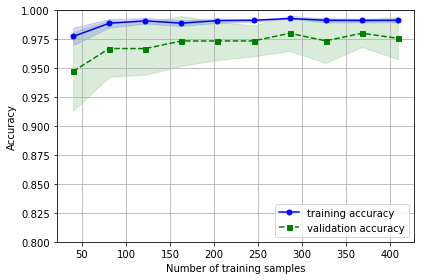

In [32]:
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve



pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10), # uses 10 evenly spaces relative intervals for the training set sizes
                               cv=10, # stratified k-fold is used by default, 10 here is equivalent to k
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes, # cool green area on graph - mapping std dev
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

***Lookin good learnin' curve!***

## 6-3-2: Validation Curves

To validate a model we need a scoring function (i.e. accuracy for classifiers), then seek to maximize this scoring function by tuning hyperparameters. A **validation curve** allows you to observe the influence of a *single hyperparameter* on the training score and validation score, which tells us whether the estimator is over- or underfitting for certain values.

In the example below, we observe the validation curve for the **inverse regularization parameter (c)** in logistic. (*Recall, regularization is the technique for simplifying a model and reducing its dimensionality. Here a low, positive float for c equates to greater regularization aka more simplification. The default value is 1.0)*

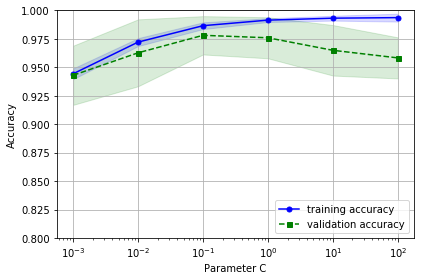

In [35]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()